The programm uses a competitive hopfield neural network to segment the image shown in the provided papers [(1)](https://www.researchgate.net/publication/262363260_Segmentation_of_industrial_X-ray_images) [(2)](https://www.researchgate.net/publication/3220680_Application_of_competitive_Hopfield_neural_network_to_medical_image_segmentation)

The matrix V contains c seperate neural networks each with n neurons. Only 1 neuron per row may be active. Neuron values can only be 1 or 0
$$
\begin{matrix}
Network\ 1 & Network\ 2 & \dots & Network\ c\\
Net_{1,1} & Net_{1,2} & \dots & Net_{1,c}\\
Net_{2,1} & Net_{2,2} & \dots  & Net_{2,c}\\
\dots & \dots & \dots  & \dots\\
Net_{n,1} & Net_{n,2} & \dots  & Net_{n,c}
\end{matrix}
$$

1. Input the gray levels of n (colors of the image, n = 255 for 8bit images), $G = \set{g_1, g_2, \dots, g_n}$ and the number of classes in the image c
2. Compute the DIS matrix and histogram H

    The distance matrix is calculated as the euclidian distance between gray-levels $DIS_{x,y} = (g_x - g_y)^2$
3. Calculate the total input of each neuron in a row x
$$
Net_{x,i}=-\frac{1}{\sum_{y=1}^n H_y * V_{y,i}} \sum_{y=1}^n DIS_{x,y} * H_y * V_{y,i}
$$
4. Apply the winner takes all learning scheme on the row x
5. Repeat 3. and 4. for all rows. If there are no changed neurons, the final state of the neurons indicates the gray levels being assigned to classes. Otherwise return to step 3

In [1]:
# imports
import numpy as np
from PIL import Image # For showing images in the notebook
import cv2 # read/write images, treshold, highlight
from tqdm.notebook import tqdm # Progress bar

In [2]:
# Loading images

# From .tiff
le = cv2.imread('LE.tif', 0).astype(np.uint8)
he = cv2.imread('HE.tif', 0).astype(np.uint8)

# From .csv
# le = np.genfromtxt('LE.csv', delimiter=',', skip_header=True)
# he = np.genfromtxt('HE.csv', delimiter=',', skip_header=True)
# le = cv2.normalize(le, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)  # Must normalize because csv contains values [0, 922]
# he = cv2.normalize(he, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)  # Must normalize because csv contains values [0, 592]

In [3]:
# Classes (splits image into c colors)
# Best results with 17 on uncropped images
c = 17

In [4]:
# Crop
# Best results with 13 classes when cropped

# Uncomment section 1 or 2 to crop

######### 1 ################
# le = le[:,150:900]
# he = he[:,150:900]
# c = 13
######### 1 ################


######### 2 ################
# def crop(imgArr):
#     "Crop black space on the left and right side of the image"
#     i=0
#     while imgArr[0][i] == 0:
#         i+=1
#     imgArr = imgArr[:,i:]
#     i = imgArr.shape[1]-1
#     while imgArr[0][i] == 0:
#         i-=1
#     return imgArr[:,:i]

# le = crop(le)
# he = crop(he)
# c = 13
######### 2 ################

In [5]:
# Initialise gray levels [0,255]
G = np.arange(256)
# Number of gray levels
n = 256
DIS = (np.tile(G, (256, 1)).transpose() - G)**2 # Euclidian distances between gray levels dis(x,y) := (G[x] - G[y])^2

In [6]:
# Calc histogram of he and le gray values
H = np.histogram(le.flatten(), 256)[0] + np.histogram(he.flatten(), 256)[0]

In [7]:
# Initializing the neural network

V = np.zeros((G.size,c))
# Random network start only shuffles the final gray-level values
# V[:,0] = 1
# for row in V:
#     np.random.shuffle(row)

In [8]:
# Network functions

def net(x, i):
    """
    Net input to the (x,i)th neuron
    
    for y in range(n):
    
        nu += d(x,y)*H[y]*V[y][i]

        de += H[y]*V[y][i]

    return -nu.sum()/de.sum()
    """
    nu = H*V[:,i] # numerator
    de = nu.sum() # denominator
    nu *= DIS[x,:] # Same as nu *= (G[x]-G[:])**2 # G[X] is turned into an array [G[x],G[x], ... ,G[x]] with length G
    return -nu.sum()/de

def wta(x, active):
    """
    'Winner take all'. Biggest value in row x is set to 1, all other 0
    
    Returns True if the active neuron changed
    """

    m = V[x].argmax()

    V[x][:] = 0
    V[x][m] = 1

    if(active != m):
        return True
    return False

In [9]:
# Running the network

def run_once(bar):
    "Update all neurons row by row. Returns True if any rows changed"
    changed = False
    bar.reset()
    for x in range(n):
        active = V[x].argmax()
        for i in range(c):
            V[x][i] = net(x, i)
        changed |= wta(x, active)
        
        bar.update(1)
    
    return changed
def run():
    "Run till limit or until there are no changing neurons"
    # Show progress bar with tqdm
    limit = 150
    i = 0
    changed = True
    with tqdm(desc="Rows updated", total=n, leave=False) as bar:
        with tqdm(desc="Iterations done", total=limit, leave=False) as pbar:
            while changed and i<limit:
                changed = run_once(bar) # stop early if there are no changes in network
                # run_once(bar) # ignore early stop
                pbar.update(1)
                i+=1
            # pbar.set_description("Processing finished")
            bar.update(n-bar.n)
            pbar.update(limit-pbar.n)
    print("Iterations done:", i)

In [10]:
run()

Rows updated:   0%|          | 0/256 [00:00<?, ?it/s]

Iterations done:   0%|          | 0/150 [00:00<?, ?it/s]

C:\Users\Luka\AppData\Local\Temp\ipykernel_4092\3121363547.py:18: RuntimeWarning: invalid value encountered in double_scalars
  return -nu.sum()/de


Iterations done: 49


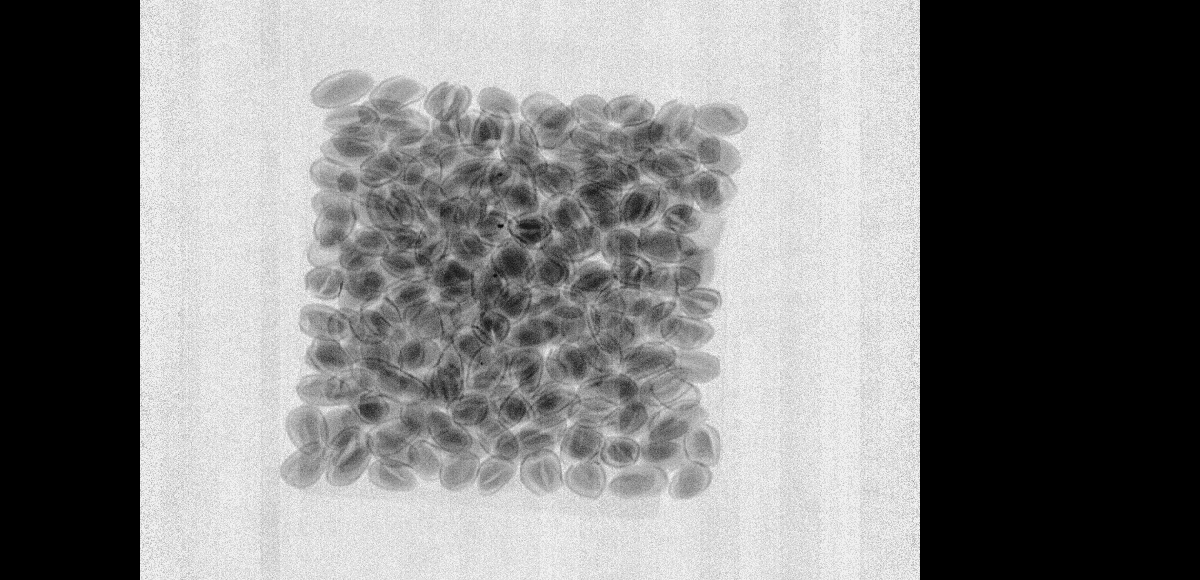

In [11]:
# Show segmented image

classValue = np.arange(0,2**8-1,(2**8-1)/c).astype(np.uint8)

# index - gray-level input
# value - gray-level representing the class (lighter to darker)
classified = (V*classValue).max(axis=1).astype(np.uint8)

# for each x in img returns classified[x]
imgArr = np.take(classified, le.flatten()).reshape(le.shape)


# Image with only c graylevels
Image.fromarray(imgArr)

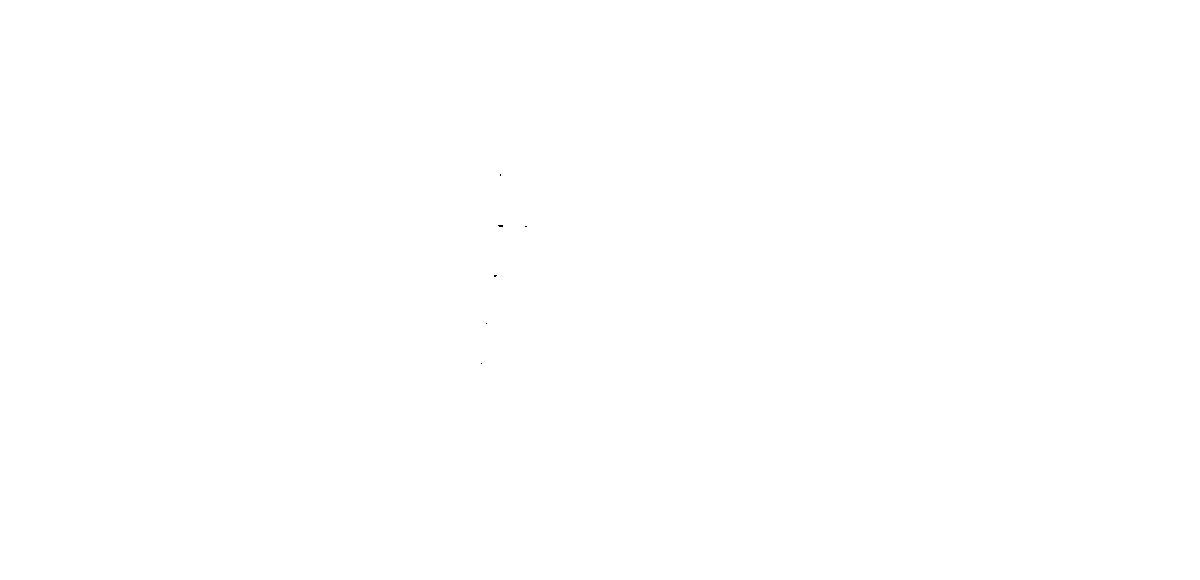

In [12]:
# Threshold

method = cv2.THRESH_BINARY # Output white background, black segments
# method = cv2.THRESH_BINARY_INV # Inverse

_, segmented = cv2.threshold(imgArr, classValue[1], 255, method)

# if the image is not cropped fills white/black margins
# Same method as crop
i=0
while segmented[0][i] == 255*method:
    i+=1
segmented[:,:i] = 255 * (not method)
i = segmented.shape[1]-1
while segmented[0][i] == 255*method:
    i-=1
segmented[:,i:] = 255 * (not method)

cv2.imwrite("output.jpg", segmented)
# cv2.imwrite("output.tiff", (segmented*2**8).astype(np.uint16))

######### End of script ###############################

Image.fromarray(segmented)

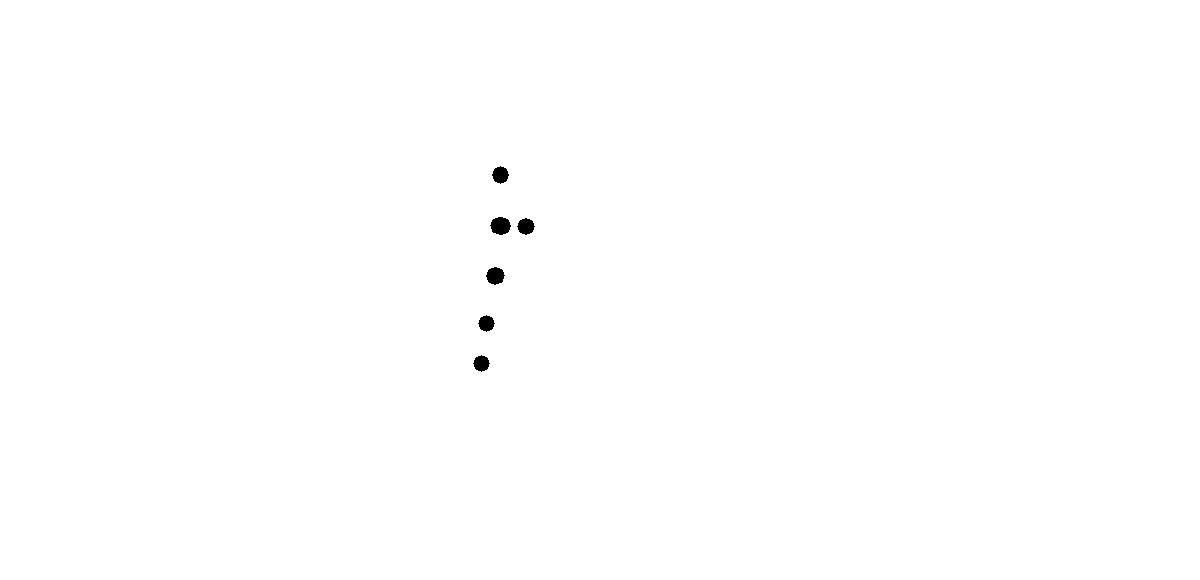

In [13]:
# Highlight

seg2 = segmented.copy()
#print(seg2.max())
cnts,_ = cv2.findContours(255 - seg2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
seg2 = cv2.drawContours(seg2, cnts, -1, 255*method, 15)
Image.fromarray(seg2)